In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pickle
import ray
from ray import tune
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import pre_process
from genome_embeddings import trainable # import before ray (?)

In [11]:
mode = "Desktop" # "CC" | "Desktop"
# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/TUNE_RESULT_DIR"

BASE_DIR = '/Users/natasha/Desktop/vae/'
#BASE_DIR ="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/TUNE_RESULT_DIR"

if mode == "Desktop":
    settings = Namespace(
        DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
        SAVE_FP = '/Users/natasha/Desktop/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
elif mode == "CC":
    settings = Namespace(
        DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/',
        SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
    

# Load data needed to make corrupted train + test datasets

In [12]:
create_new = False
from_scratch = False # controls where in creation process to jump in

# Create list of which genomes from KEGG to include in dataset
tla_to_tnum, keepers = pre_process.genomes2include(mode)
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
org_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum, mode)
org_to_mod_to_kos, mod_sets = pre_process.load_mods(mode)
mod_to_kos = pre_process.create_mod_to_kos(org_to_mod_to_kos)

if create_new:
    if from_scratch:
        # Load list mods and KOs per genome
        data, genome_order = pre_process.make_tensor(org_to_mod_to_kos, org_to_kos, n_kos_tot, tla_to_tnum, all_kos)
        torch.save(data, BASE_DIR+"kegg_v2.pt")
        torch.save(genome_order, BASE_DIR+"genome_order.pt")
    else:
        # load data -- tensor (genomes + which KOs are encoded) + genome_order in tensor (tla)
        data = torch.load(BASE_DIR+"kegg_v2.pt")
        genome_order = torch.load(BASE_DIR+"genome_order.pt")
    
    # Create test-train split
    train_genomes, test_genomes = pre_process.train_test_split(keepers) # list of IDs to keep
    train_data = pre_process.prep_data(train_genomes, all_kos, org_to_kos, "train")
    test_data = pre_process.prep_data(test_genomes, all_kos, org_to_kos, "test")
    
    torch.save(all_kos, BASE_DIR+"all_kos_2020-09-29.pt")
    torch.save(org_to_mod_to_kos, BASE_DIR+"org_to_mod_to_kos_2020-09-29.pt")
    torch.save(train_data, BASE_DIR+"kegg_v2_train_2020-09-29.pt")
    torch.save(test_data, BASE_DIR+"kegg_v2_test_2020-09-29.pt")
    torch.save(train_genomes, BASE_DIR+"kegg_v2_train_genomes_2020-09-29.pt")
    torch.save(test_genomes, BASE_DIR+"kegg_v2_test_genomes_2020-09-29.pt")
else:
    all_kos = torch.load(BASE_DIR+"all_kos_2020-09-29.pt")
    org_to_mod_to_kos = torch.load(BASE_DIR+"org_to_mod_to_kos_2020-09-29.pt")
    train_data = torch.load(BASE_DIR+"kegg_v2_train_2020-09-29.pt")
    test_data = torch.load(BASE_DIR+"kegg_v2_test_2020-09-29.pt")
    train_genomes = torch.load(BASE_DIR+"kegg_v2_train_genomes_2020-09-29.pt")
    test_genomes = torch.load(BASE_DIR+"kegg_v2_test_genomes_2020-09-29.pt")

mod_to_ko_clean = pre_process.clean_kos(mod_sets)

Total number of bacterial genomes in dataset: 2718
Total number of KOs in dataset: 9874


# Filter dataset

In [13]:
# Remove any genomes with fewer than n_min KOs 
n_min = 500
good_idx_train = train_data.sum(axis=1) >= n_min
good_idx_test = test_data.sum(axis=1) >= n_min
train_data = train_data[good_idx_train,:]
test_data = test_data[good_idx_test,:]

# to numpy for indexing, then back to list for using
train_genomes = list(np.array(train_genomes)[good_idx_train])
test_genomes = list(np.array(test_genomes)[good_idx_test])

In [14]:
# get rid of genomes that encode fewer than 10 modules
train_data, train_genomes = pre_process.remove_duds(train_data, train_genomes, tnum_to_tla, org_to_mod_to_kos)
test_data, test_genomes = pre_process.remove_duds(test_data, test_genomes, tnum_to_tla, org_to_mod_to_kos)

In [15]:
# Are there any columns that are all zeros in both the train and test sets (TL;DR yes)
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

In [16]:
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 77)

In [17]:
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

In [653]:
train_data.shape, test_data.shape, train_data.shape[0]+test_data.shape[0]

((2305, 9863), (279, 9863), 2584)

# Data exploration

In [ ]:
# mod = 'M00001'
# a = list(mod_sets[mod].values())
# a.sort(reverse=True)
# x_labels = [i for i in range(len(mod_sets[mod].values()))]
# plt.bar(x_labels, a)
# plt.yscale('log')
# plt.title("Variants of module "+mod)
# plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
# plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
# print(max(mod_sets[mod].values()), len(a))

In [ ]:
# Plot the number of KOs encoded by each genome
# Note: this includes genomes excluded from the final dataset!
plt.hist([len(org_to_kos[i]) for i in org_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig(BASE_DIR+"fig.png")

In [ ]:
lens = [len(org_to_kos[i]) for i in org_to_kos if i in train_genomes or i in test_genomes]
print(np.median(lens), min(lens), max(lens))

In [ ]:
# # Plot the number of modules encoded by each genome
# n_genomes = len(org_to_mod_to_kos)
# temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
# n_mods = len(list(set([item for sublist in temp for item in sublist])))
# plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
# plt.xlabel("Number of modules per genome")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")

In [ ]:
# a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
# a.sort()
# print("There are "+str(a.count(0))+" genomes with zero modules")

# # Red
# # Rue
# # pvac
# # cgw

In [ ]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

In [ ]:
# # Count and plot the number of genomes that encode each module
# mods_count = defaultdict(int)
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         mods_count[mod] += 1
        
# plt.hist(mods_count.values(), 50)
# plt.xlabel("Number of genomes encoding each module")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
# plt.yscale('log')
# print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [ ]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in org_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(org_to_kos[tla])
#         n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [ ]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         kos_in_mods.extend(org_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [ ]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in org_to_mod_to_kos:
#         for mod in org_to_mod_to_kos[org]:
#             if ko in org_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [ ]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [ ]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [ ]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# Corrupt input genomes

In [ ]:
# 1-10 genomes: 5000 corrupted versions
# 10 - 100 genomes: 1000 corrupted versions
# 100-1000 genomes: 500 corrupted versions
# 1000 - 10000 genomes: 100 corrupted versions

# precorruption (pc) -- get dicts to map genome tla back to list of phylum, class, etc

### HELLO MONDAY MORNING TASH
# This was supposed to run with the following corruptions (even though it says otherwise in corrupt2)
# count_to_corrupt = {10: 50, 100: 10, 1000: 5, 10000: 1}
# Make sure it works
# Then check out real results {10: 5000, 100: 1000, 1000: 500, 10000: 100} on CC
#corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt2(train_data, train_genomes, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos)


In [ ]:
c_train_genomes

In [ ]:
counts = defaultdict(int)
for i in c_train_genomes:
    counts[i] += 1

print (counts)

In [19]:
# corrupt version 1 -- extreme corruption
# 2020-09-04: select 1-10 mods for input
# 2020-10-16_10mods: select 10 mods for input, genomes with fewer than 10 mods are eliminated
# 2020-10-16_1mods: select 1 mods for input, genomes with fewer than 10 mods are eliminated 

new_corrupt = False
#date_to_save = "2020-12-04_10mods" # uses corrupt2
#date_to_save = "2020-12-03_10mods" # has no genomes with < 1000 KOs
date_to_load = "2020-12-02_10mods" # has no genomes with < 500 KOs 
#date_to_load = "2020-10-16_10mods" # has 9874 features, including a few that are all zeros in both train + test
num_corruptions = 100
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}

if new_corrupt:
    #tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
    corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt2(train_data, train_genomes, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, mode)
    corrupted_test, c_test_genomes, test_input_mods = corrupt.corrupt2(test_data, test_genomes, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, mode)
    torch.save(corrupted_train, BASE_DIR+"corrupted_train_"+date_to_save+".pt")
    torch.save(c_train_genomes, BASE_DIR+"c_train_genomes_"+date_to_save+".pt")
    torch.save(corrupted_test, BASE_DIR+"corrupted_test_"+date_to_save+".pt")
    torch.save(c_test_genomes, BASE_DIR+"c_test_genomes_"+date_to_save+".pt")
    torch.save(train_input_mods, BASE_DIR+"train_input_mods_"+date_to_save+".pt")
    torch.save(test_input_mods, BASE_DIR+"test_input_mods_"+date_to_save+".pt")
else:
    corrupted_train = torch.load(BASE_DIR+"corrupted_train_"+date_to_load+".pt")
    c_train_genomes = torch.load(BASE_DIR+"c_train_genomes_"+date_to_load+".pt")
    corrupted_test = torch.load(BASE_DIR+"corrupted_test_"+date_to_load+".pt")
    c_test_genomes = torch.load(BASE_DIR+"c_test_genomes_"+date_to_load+".pt")
    train_input_mods = torch.load(BASE_DIR+"train_input_mods_"+date_to_load+".pt")
    test_input_mods = torch.load(BASE_DIR+"test_input_mods_"+date_to_load+".pt")

In [20]:
# confirm that there are no all-zero rows
non_zero_idx = corrupted_train.sum(axis=1) > n_min
len(non_zero_idx), corrupted_train.shape[0]

(230500, 230500)

In [21]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

# Visualization of final datasets

In [ ]:
fig, labels, y3 = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes)
plt.savefig(BASE_DIR+"fig_dist.png", bbox_inches='tight')

In [ ]:
def get_lengths(c_genomes, org_to_kos):
    lens = []
    for i in list(set(c_genomes)):
        tnum = tla_to_tnum[i]
        lens.append(len(org_to_kos[tnum]))
    return lens

train_lens = get_lengths(c_train_genomes, org_to_kos)
test_lens = get_lengths(c_test_genomes, org_to_kos)

In [ ]:
# Plot the number of KOs encoded by each genome
fig, ax = plt.subplots()
plt.hist(train_lens, 50, color='#3385ff')
plt.hist(test_lens, 50, color='#bb99ff')
ax.legend(['Train', 'Test'])
plt.xlabel("# annotated genes / genome")
plt.ylabel("Count")
plt.savefig(BASE_DIR+"fig.png")
plt.ylim(0,125)
plt.xlim(0,max(train_lens)+10)
plt.savefig(BASE_DIR+"fig_ko_dist.png", bbox_inches='tight')

In [ ]:
# How many modules are there per training genome?
from collections import defaultdict
mods_count = defaultdict(int)
for org in org_to_mod_to_kos:
    if org in c_train_genomes:
        mods_count[org] = len(org_to_mod_to_kos[org])
plt.hist(mods_count.values())
plt.xlabel('Number of modules')
plt.ylabel('Number of genomes')

# HPO w/ Ray Tune: Define and train network

In [ ]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

In [ ]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": settings.replacement_threshold,
         "nn_layers": tune.choice([1, 2, 3, 4]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [ ]:
analysis = tune.run(
    trainable.train_AE, 
    name="04_12_2020_vae",
    config=config,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    num_samples=20,  
    queue_trials=True,
    #local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
    )

In [ ]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# analysis.get_best_config(metric="test_f1")

# Single model: Define and train network

In [ ]:
nn_layers = 3
weight_decay = 0.1
lr = 0.001
batch_size = 128
kfolds = 10
num_epochs = 10
replacement_threshold = 0.5

kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, batch_size, kfolds, num_epochs, replacement_threshold, corrupted_train, corrupted_test)


In [ ]:
torch.save(model.state_dict(), BASE_DIR+"model.pt")
torch.save(train_losses, BASE_DIR+"train_losses.pt")
torch.save(test_losses, BASE_DIR+"test_losses.pt")
torch.save(bce0, BASE_DIR+"bce0.pt")
torch.save(kld0, BASE_DIR+"kld0.pt")
torch.save(train_f1s, BASE_DIR+"train_f1s.pt")
torch.save(test_f1s, BASE_DIR+"test_f1s.pt")

In [716]:
load_model = True
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load(BASE_DIR+"model.pt"))
    train_losses = torch.load(BASE_DIR+"train_losses.pt")
    test_losses = torch.load(BASE_DIR+"test_losses.pt")
    train_f1s = torch.load(BASE_DIR+"train_f1s.pt")
    test_f1s = torch.load(BASE_DIR+"test_f1s.pt")
    bce0 = torch.load(BASE_DIR+"bce0.pt")
    kld0 = torch.load(BASE_DIR+"kld0.pt")

# Evaluate model performance

### Generate predictions on test set

In [711]:
# 1-10 modules per input genome: 0.74
# 1 module per input genome: 0.64
# 10 modules per input genome: 0.81
n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

In [730]:
model.eval()
with torch.no_grad():
    pred = model.forward(corrupted)[0].detach()
binary_pred = evaluate.eval_binarize(pred, 0.5)

### Investigate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [731]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print("Test set F1 score",f1)

Test set F1 score 0.8186415301434072


median F1 score: 0.8263595450132714 min 0.45439999999999997 max 0.9891674404209223


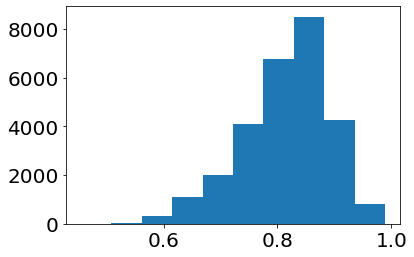

In [732]:
f1s, fig = evaluate.test_f1s(uncorrupted, binary_pred)

In [880]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


83.02 2.24 2.98 11.77


In [881]:
tns[0]

7544

### Examine at BCE vs KLD loss

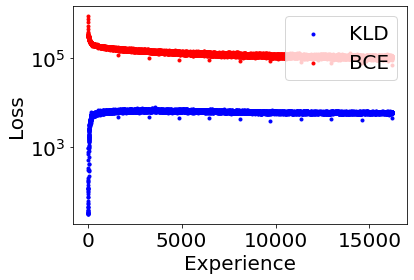

In [718]:
# Plot BCE and KLD vs experience
data_viz.kld_vs_bce(kld0,bce0)

### Plot learning curves

max F1 score 0.8793126292915853


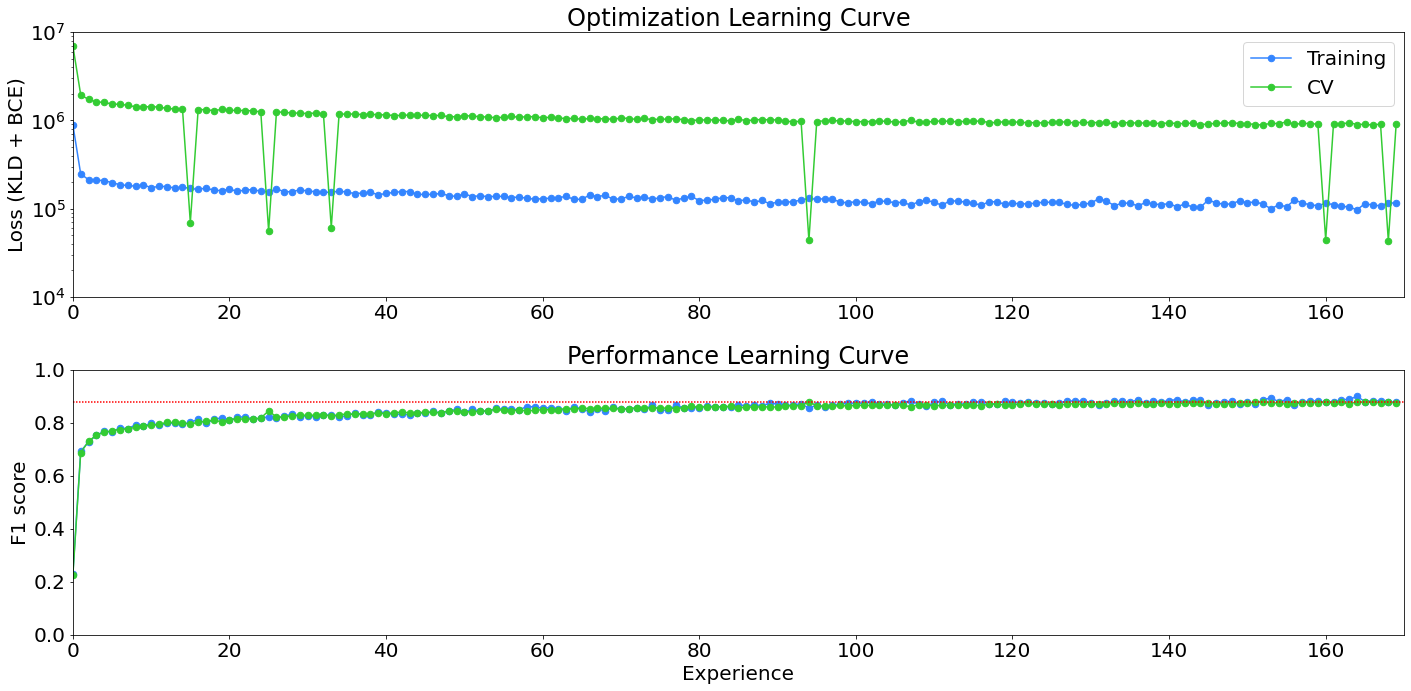

In [719]:
fig = data_viz.learning_curve(train_losses, test_losses, train_f1s, test_f1s)
plt.savefig(BASE_DIR+"learning_curves.png", bbox_inches='tight')

### Plot ROC curve and generate AUC score (micro-average)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


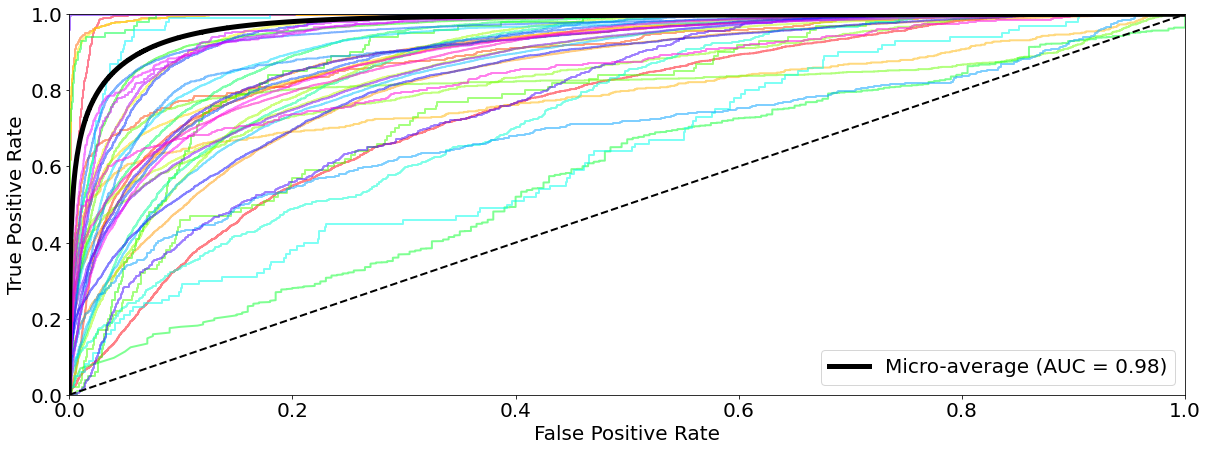

In [652]:
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())
fig.savefig(BASE_DIR+"roc_fig.png", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

There are 5716 instance of inputs being 100% present in output
This is out of 27900 instances or 20.49% of cases
There are 23653 instance of inputs being >=90% present in output (84.78%)


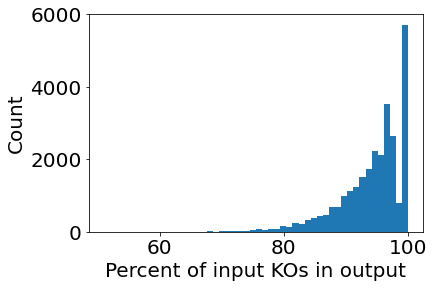

In [654]:
# relabel y axis by % rather than count
fig = evaluate.compare_in_n_out(binary_pred, corrupted)
fig.savefig(BASE_DIR+"input_vs_output.png", bbox_inches='tight', dpi=200)

### What are the best and worst performing instances?

In [720]:
# babt = Brucella abortus
idx_best = f1s.index(max(f1s))
tla_best = c_test_genomes[idx_best]
idx_best, tla_best, f1s[idx_best], tla_to_tnum[tla_best]

(3610, 'babt', 0.9894671623296158, 'T03461')

In [721]:
# nmv = Nitrospira moscoviensis
# seny = Pectobacteriaceae sodalis (Gammaprot), endosymbiont of Henestaris halophilus
# bmx
idx_worst = f1s.index(min(f1s))
tla_worst = c_test_genomes[idx_worst]
idx_worst, tla_worst, f1s[idx_worst], tla_to_tnum[tla_worst]

(4607, 'bmx', 0.4694724362774156, 'T01659')

### For the best scoring instance, plot pixel diagram

tn 8230 fp 25 fn 11 tp 1597
0.9888544891640867
9863
n_features 9863 len(colour_pred) 9863 n_extension 37
9900


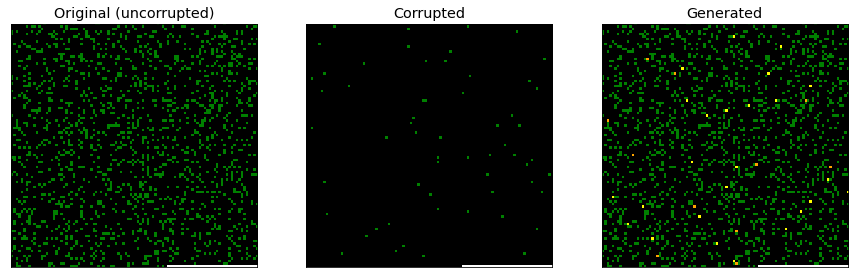

In [1016]:
idx = idx_best
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.png", bbox_inches='tight', dpi=200)

In [743]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_best,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_best,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_best,:]))

Num genes on in uncorrupted idx_best genome tensor(1608.)
Num genes off in uncorrupted idx_best genome tensor(8255.)
Num genes on in corrupted idx_best genome tensor(59.)


babt F1: 0.9891674404209223

bbg F1: 0.9873908826382153

dec F1: 0.9731462925851704



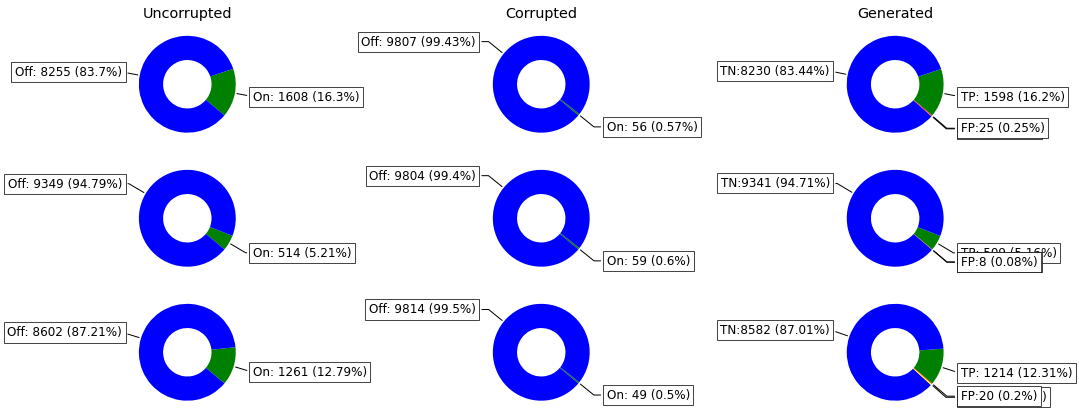

In [1014]:
fig = evaluate.pie_chart_reconstructions(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted)
fig.savefig(BASE_DIR+"pie_plots.pdf", bbox_inches='tight', dpi=200)

labels ['TN', 'TP', 'FP', 'FN']
babt F1: 0.9891674404209223
generated genome: [1598, 8230, 10, 25]
generated genome: [16.2, 83.44, 0.1, 0.25]

bbg F1: 0.9873908826382153
generated genome: [509, 9341, 5, 8]
generated genome: [5.16, 94.71, 0.05, 0.08]

dec F1: 0.9731462925851704
generated genome: [1214, 8582, 47, 20]
generated genome: [12.31, 87.01, 0.48, 0.2]



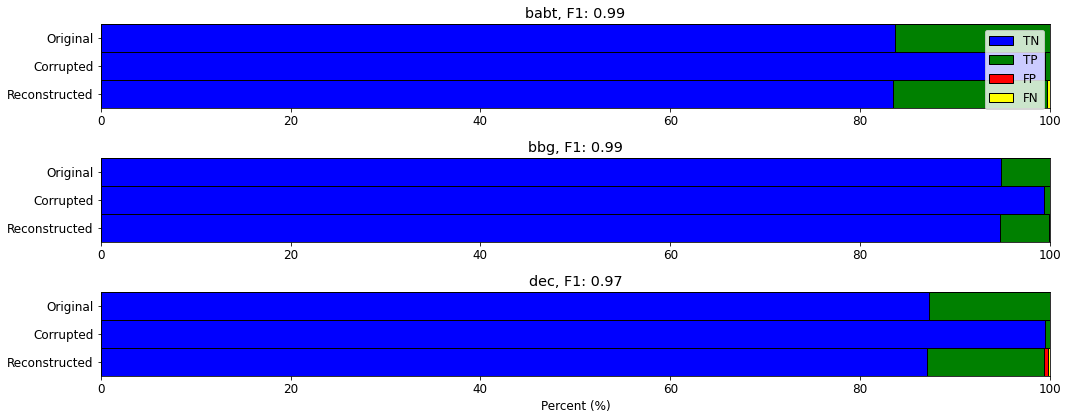

In [1199]:
fig = evaluate.plot_reconstruction_barh(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted)
fig.savefig(BASE_DIR+"reconstruction_bar.pdf", bbox_inches='tight', dpi=200)

### For the worst scoring instance, plot pixel diagram

In [ ]:
idx = idx_worst
fig = data_viz.genome_heatmap2(corrupted_test, idx, model)
fig.savefig(BASE_DIR+"fig4.png", bbox_inches='tight', dpi=200)

In [ ]:
# print median TNs, FPs, FNs, TPs
np.median(tns), np.median(fps), np.median(fns), np.median(tps)

### How does the model perform on inputs originating from different phyla

In [248]:
# get dicts to map genome tla back to list of phylum, class, etc
train_tax_dict, test_tax_dict = data_viz.tax_distribution(c_train_genomes, c_test_genomes, 'Desktop')

In [528]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)

Best: Deinococcus-Thermus 0.9078893019413466
Worst: Acidobacteria 0.6495664739884393


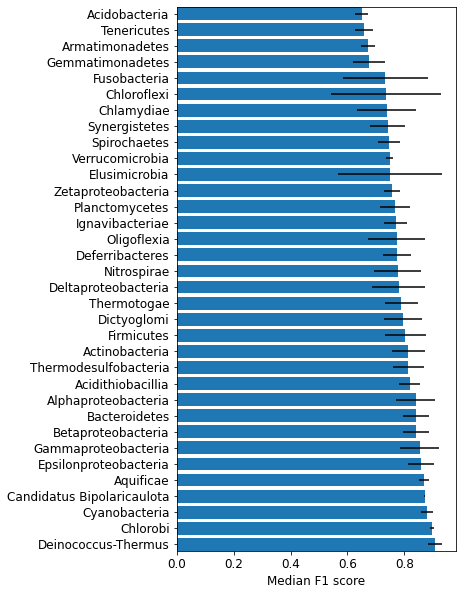

In [587]:
# Bars represent median absolute deviation
fig_save_for_later = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
fig_save_for_later.savefig(BASE_DIR+"f1_per_phylum.png", dpi=200, bbox_inches='tight')

In [567]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

KruskalResult(statistic=5109.2137754448095, pvalue=0.0)

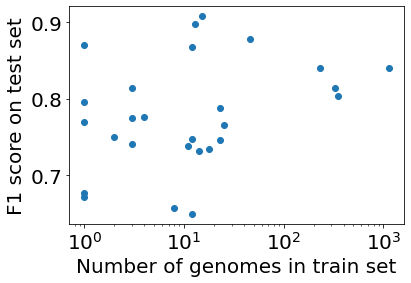

In [522]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?

In [508]:
# Number of times each mod occurs in the training set corrupted genomes
train_out = evaluate.train_out(train_input_mods)

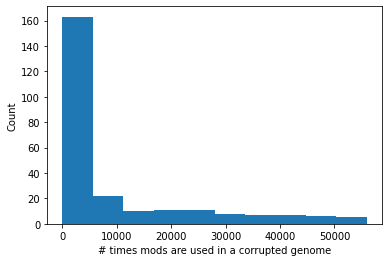

In [509]:
fig = evaluate.plot_train_count_hist(train_out)

### How does genome size correlate with F1 score

In [ ]:
# x-axis = # genes in input genome
# y-axis = F1 score of reconstructed genomes

In [ ]:
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in uncorrupted genome")
plt.ylabel("F1 score")

In [ ]:
n_genes_corrupted = torch.sum(corrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_corrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in corrupted input")
plt.ylabel("F1 score")

### How much variance is there in the F1 score of genomes encoding certain modules?
Do some modules / lifestyles get reconstructed better than others?

In [497]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod()

In [498]:
#fig, done = evaluate.plot_mod_count_vs_f1(test_input_mods, c_test_genomes, train_input_mods, f1s)

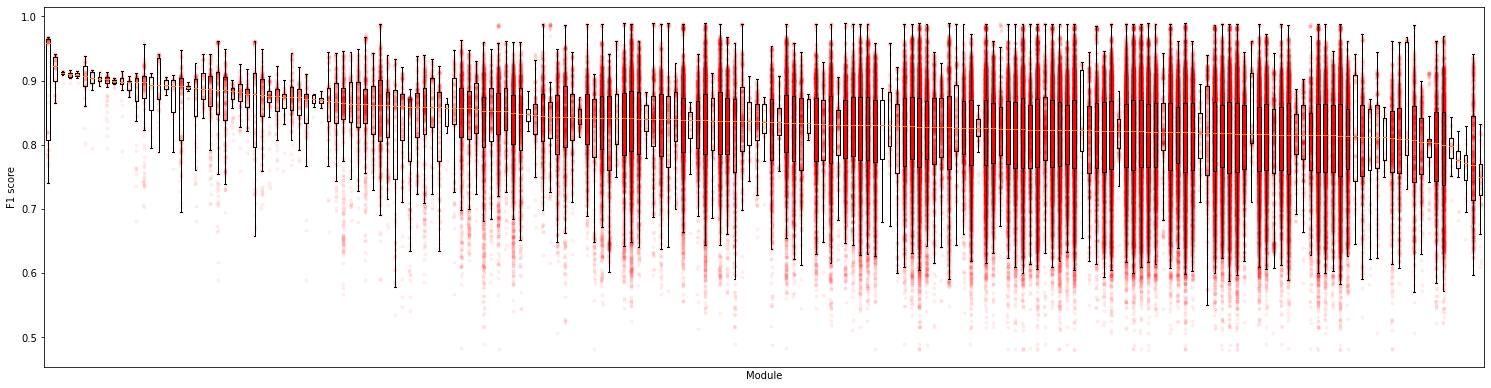

In [504]:
fig = evaluate.plot_mod_vs_f1(test_input_mods, f1s)

In [500]:
# Plot whether number of modules in process correlates with F1 score
# More interchangeable options = worse performance?

In [501]:
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

In [502]:
# fig = evaluate.plot_metab_pathway_f1(subprocess_to_mod, test_input_mods, f1s)

### Analyze F1 scores of actual KOs

In [487]:
### THIS MUST BE USED IN MULTIPLE PLACES
ko_f1s = []
for i in range(uncorrupted.shape[1]): # for every column
    f1 = sk.metrics.f1_score(uncorrupted[:,i], binary_pred[:,i], zero_division=0)
    ko_f1s.append(f1)

In [488]:
zeros = 0
for i in ko_f1s:
    if i == 0:
        zeros += 1
print(zeros, len(ko_f1s), zeros/len(ko_f1s)*100)

2197 9863 22.27516982662476


In [489]:
# In the training set, how many KOs are always zero?
zeros_train = train_data.sum(axis=0) > 0
n_ones = np.sum(zeros_train)
n_zeros_train = len(zeros_train) - n_ones
print("There are",n_zeros_train,"genes that are always off in the training set")

There are 77 genes that are always off in the training set


Text(0, 0.5, 'Count')

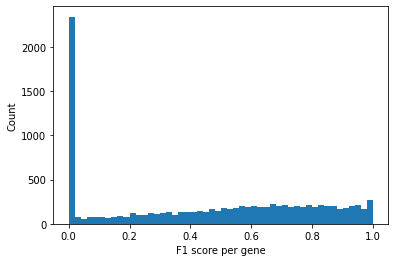

In [490]:
fig = plt.figure()
plt.hist(ko_f1s, bins = 50)
plt.xlabel("F1 score per gene")
plt.ylabel("Count")

max KO count: 230300 , total number of training genomes: 230500


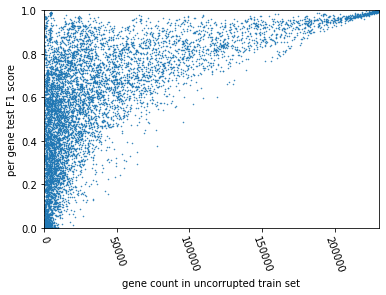

In [491]:
# gene occurence in uncorrupted ds vs F1 score
#ko_counts = torch.sum(uncorrupted, 0)
# get gene occurence in uncorrupted training set
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)

fig, ax = plt.subplots()
plt.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax.set_xlim(0, tr_uncorrupted.shape[0])
ax.set_ylim(0,1)
plt.xlabel("gene count in uncorrupted train set")
plt.ylabel("per gene test F1 score")
plt.xticks(rotation=-70)
print("max KO count:",int(max(ko_counts)), ", total number of training genomes:",tr_uncorrupted.shape[0])

In [492]:
# F1 score on KOs + what metab pathway they are part of

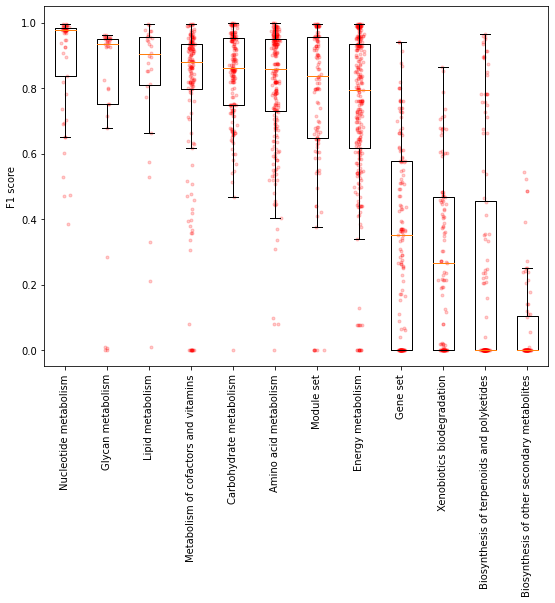

In [505]:
fig = evaluate.plot_metab_pathway_f1_v2(process_to_mod, mod_to_kos, all_kos, ko_f1s, (7,5))

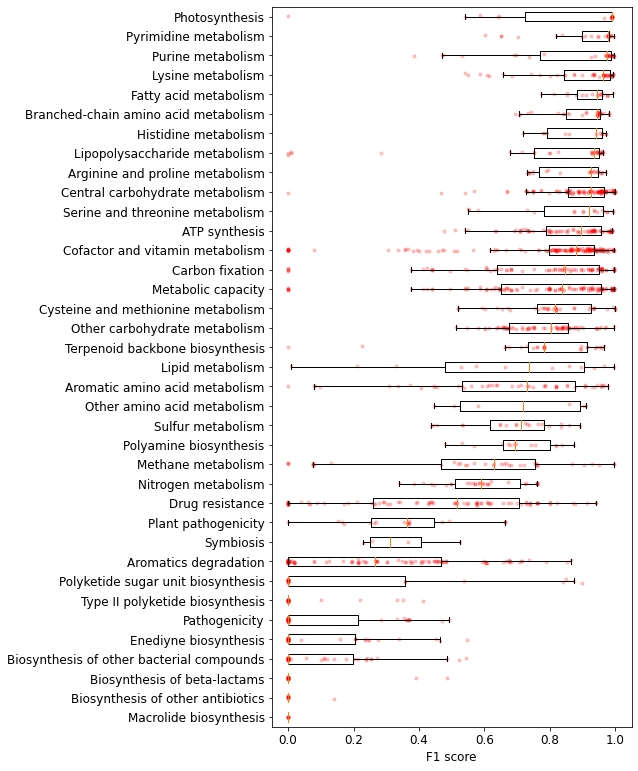

In [643]:
# can also do horizontal boxplot with fig = evaluate.plot_metab_pathway_f1_v2
fig = evaluate.plot_metab_pathway_f1_v2_horizontal(subprocess_to_mod, mod_to_kos, all_kos, ko_f1s, (5,10))
fig.savefig(BASE_DIR+"f1_per_proc.png", dpi=200, bbox_inches='tight')

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

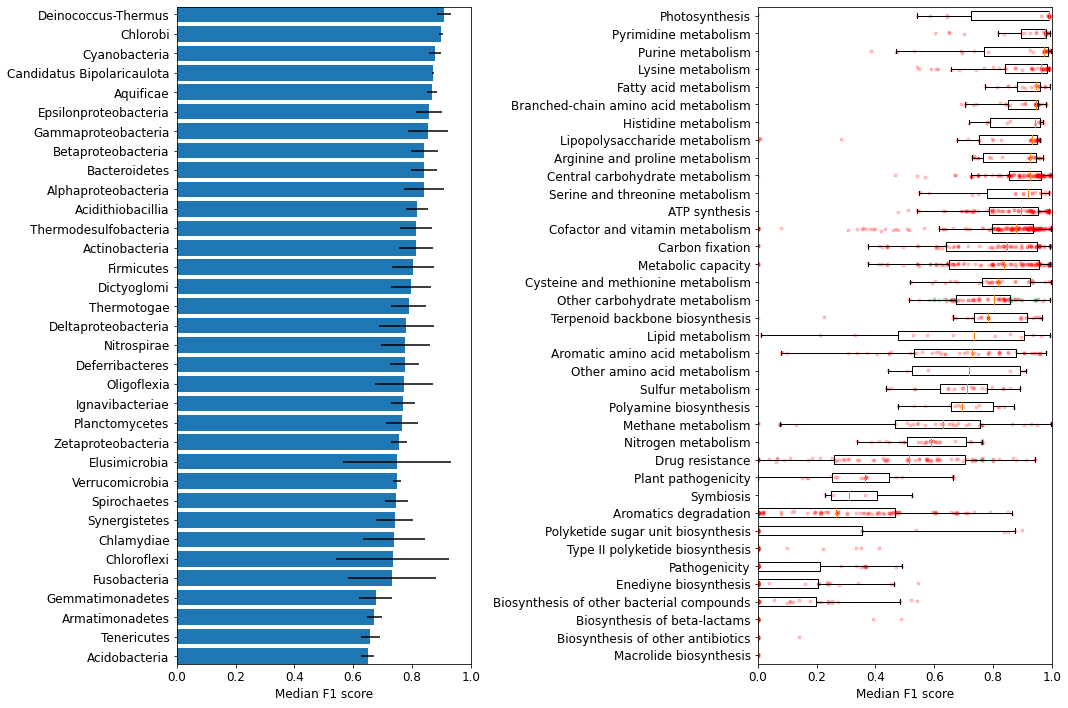

In [644]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_kos)
fig.savefig(BASE_DIR+"bio_insights_fig.png", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

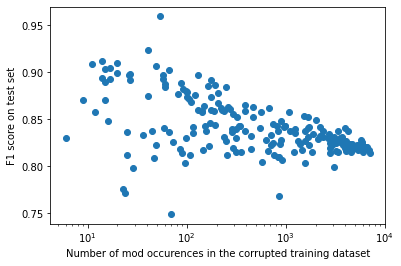

In [510]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Qualitatively compare distance of real vs generated genomes

### Plot PCA of Jaccard similarity between genomes, using Hamming distances as a metric

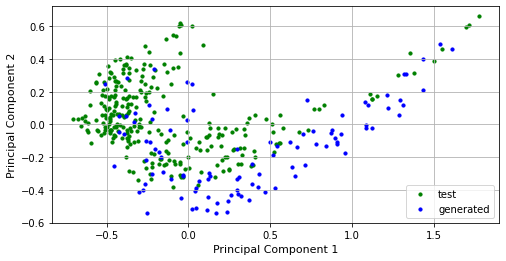

In [486]:
fig = evaluate.plot_dist(all_kos, mod_to_kos, model, test_data)
fig.savefig(BASE_DIR+"pca_jaccard.png", dpi=200, bbox_inches='tight');

### Create files needed to infer and visualize a dendrogram based on gene prescence/abscence
Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL for visualization (display, add colour strips, remove taxon labels)

In [479]:
# Create input for phylip
df = evaluate.df_for_phylip(all_kos, mod_to_kos, model, test_data, test_genomes)
phylum_dict = evaluate.write_out_for_phylip(BASE_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt

In [473]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(BASE_DIR, phyla_done, phylum_dict) # vae_dendro_colours_real.txt
#colour = tuple(np.random.randint(256, size=3))

In [466]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(BASE_DIR, phylum_dict) # vae_dendro_colours_generated.txt

# Baseline models

In [ ]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [ ]:
new = True

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, BASE_DIR+"baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load(BASE_DIR+"baseline1.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [651]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

NameError: name 'baseline1' is not defined

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [ ]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, BASE_DIR+"baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load(BASE_DIR+"baseline2.pt")
    

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [ ]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, BASE_DIR+"baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load(BASE_DIR+"baseline3.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [ ]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline4, BASE_DIR+"baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load(BASE_DIR+"baseline4.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [ ]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline5, BASE_DIR+"baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load(BASE_DIR+"baseline5.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())

# Potential model improvements

In [ ]:
# Increase dataset set (more corruptions per genome)
# For genomes it does poorly on, make more copies
# HP tuning
# Remove genomes with <1000 KOs ---> get rid of endosymbionts --- will need to redo small genome baseline
# Apply different amounts of KLD importance during training
# Make 100% of input genes in output (currently ~20% have 100% in and out). Loss mod?

In [ ]:
# We performed a parameter sweep over warmups (κ) (0.01, 0.05, 0.1, and 1). 
# κ controls how much the KL divergence loss contributes to learning, 
# which effectively transitions a deterministic autoencoder to a VAE.28,29 
# For instance, a κ = 0.1 would add 0.1 to a weight on the KL loss after each epoch. 
# After 10 epochs, the KL loss will have equal weight as the reconstruction loss. 
# We did not observe κ to influence model training (Figure 1B), so we kept κ = 1 for downstream analyses.

# Model output to KAAS input

In [ ]:
save_to = BASE_DIR+'prot_out.txt'
ko_new = evaluate.new_genome_random(mod_to_kos, model, all_kos, save_to, BASE_DIR)

In [ ]:
len(ko_new)